# Coursework 2: Robotic behavioural cloning from images and actuator data

## Description
For this coursework, you are required to develop a behaviour cloning model. Behaviour cloning is a technique for training robotic agents using a dataset of sequences of actions. Consider the supervised learning definition where we have a dataset of observatios $d=\{(x_{1},y_{1}),...,(x_{n},y_{n})\}$ and the aim is to learn a function: $f:\mathcal{X}\rightarrow\mathcal{Y}$. In this case, $\mathcal{X}$ is the set of "observations" that the robot makes and $\mathcal{Y}$ is the set of actions that the robot takes.

The dataset you have been provided with contains examples of robot arms being required to pickup objects or drop objects (given it has already picked the object up) in a specific place. The observation space ($\mathcal{X}$) consists of:
- "front_cam_ob": A 3rd person image of the scene
- "mount_cam_ob": An image of the scene taken from a camera mounted on top of the robotic arm, looking down
- "ee_cartesian_pos_ob": The positional and orientation co-ordinates of the robotic arm
- "ee_cartesian_vel_ob": The velocity of position and orientation of the robotic arm
- "joint_pos_ob": The position of the gripper which opens and closes

The action space ($\mathcal{Y}$) consists of:
- Three co-ordinates defining how much to move the robotic arm
- An action defining whether to open, not to move or close the gripper

The dataset is split into "trajectories" i.e., sequences of:
- $x_{i}$: The front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob, joint_pos_ob __at time point i__
- $y_{i}$: The action taken i.e., how to move the arm and the gripper __given the observations__ in $x_{i}$

More information on the dataset can be found at: https://github.com/clvrai/clvr_jaco_play_dataset?tab=readme-ov-file

### Task
Your task has been split into several questions, each exploring how to develop an appropriate model for learning $f:\mathcal{X}\rightarrow\mathcal{Y}$. The task will require you to:
- Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions: You will be required to evaluate a proposed deep learning architecture (which takes as input all of front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob and predict the two actions) and propose a new model which outperforms the existing model;
- Question 2: Define and evaluate a VAE model for performing self-supervised learning and tune it as best you can, to learn a latent representation that can be used as input to a downstream supervised model for behaviour cloning
- Question 3: Evaluate the performance of your model proposed in question 1 against your self-supervised VAE representations from question 2 (plus a supervised head) on the test set

### Pointers
Some helper functions have been provided for you including the following functionality:
- A training and validation loop capabale of:
  - Handling "half-precision" modelling;
  - Logging results to weights and biases;
- An eda template to help you visualise the data
- An evaluation template to help you load saved model checkpoints from weights and biases
- A preprocessing script to help you convert the data into train/validation and test splits;
  - In this preprocessing script, trajectories longer than 75 timesteps have been removed to ease the computational requirements of the task;
- A torch Dataset class capable of handling the multi-model nature of the data;
- A example collate_fn to use in Dataloaders

Additionally, it is strongly suggested to call ```torch.manual_seed(1)``` whenever you initialise your model (i.e., when you first create the model or call model.reset()). This will ensure the parameters are initialised at the same value each time.

### IMPORTANT
- You are __not__ allowed to use pre-trained models, developed outside of this coursework i.e., you could __not__ use a pre-trained YOLO model
- Questions have been marked under the title "Task", ensure that you answer/address all of the bullet points under these headings


## Data download
Download the data for the project from here: https://drive.usercontent.google.com/download?id=1tVSilmXhyQd8gxZAEhvKMnynw0qzRFSZ&authuser=0

Save the data locally at: ../data/all_play_data_diverse or in Google Collab at: /content/drive/MyDrive/comp0188_2425/cw2. Saving the data in these locations will ensure the proprocessing script provided runs correctly. If you would like to alter these locations, you can alter them in the config.py file of the provided comp0188_cw2 package via the ROOT_PATH global variable.

### transition_df.csv
You have additionally been provided with a csv called "transition_df.csv". This contains a row for each observation/action pair in the dataset and is used to generate the train/validation and test datasets for this task. Note that this csv contains all trajectories (even those over 75 timesteps). This csv might also be useful for EDA. The transition_df.csv should be placed in the same folder that you placed the raw data in (discussed above).

## Imports

The comp0188_cw2 contains some config functionality so that you can run the code in collab and locally (to test models)! When you first import the package, import the project_options and set the appropriate configs.
- project_options.collab = True will set the dataset directories for google collab whilst false will set suitable local directories
- project_options.debug = True will load a subset of data whilst False will load all of the data.

__IMPORTANT__: Alterting these options __once you have loaded other functionality__ from comp0188_cw2 may result in unintended outcomes.

In [2]:
COLLAB = True
if COLLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install --force-reinstall git+https://github.com/joshuaspear/pymlrf.git
    !pip install wandb
    !pip install torchinfo
    !pip install jaxtyping
    !pip install git+https://github.com/joshuaspear/comp0188_cw2_public.git
    !pip install typeguard==2.13.3

Mounted at /content/drive
  Cloning https://github.com/joshuaspear/pymlrf.git to /tmp/pip-req-build-5yrmmvns
  Running command git clone --filter=blob:none --quiet https://github.com/joshuaspear/pymlrf.git /tmp/pip-req-build-5yrmmvns
  Resolved https://github.com/joshuaspear/pymlrf.git to commit 2e86313edd7900c1b5621b4e31368a36328b69f8
  Preparing metadata (setup.py) ... done
  Created wheel for pymlrf: filename=pymlrf-1.0.0-py3-none-any.whl size=20447 sha256=67b053cbfc9f3268787857daf120099e6c2173f4b32eb746dcbf9cf2c7b29933
  Stored in directory: /tmp/pip-ephem-wheel-cache-q77lyxov/wheels/b5/e9/53/587b30108dd50ceffb743ada10dd85037096182424fb2c907e
Successfully built pymlrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.2 MB/s eta 0:00:00
  Cloning https://github.com/joshuaspear/comp0188_cw2_public.git to /tmp/pip-req-build-86hq9_j6
  Running command git clone --filter=blob:none --quiet https://github.com/joshuaspear/comp0188_cw2_public.git /tmp/pip-req-build-86hq9_j6
  Resol

Ignore the error:
```ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.```

In [3]:
from comp0188_cw2 import project_options
project_options.collab = COLLAB
print(project_options.collab)
project_options.debug = True
print(project_options.debug)

True
True


In [4]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import datetime
from pymlrf.Structs.torch import DatasetOutput
import copy

from comp0188_cw2.utils import load_all_files
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import datetime
from typing import List
from pymlrf.Structs.torch import DatasetOutput

from comp0188_cw2.config import (
    train_dh, val_dh, test_dh, WANDB_PROJECT
    )
from comp0188_cw2.models.CNNConfig import ConvolutionLayersConfig
from comp0188_cw2.models.base import BaseModel
from comp0188_cw2.models.JointCNNEncoder import JointCNNEncoder
from comp0188_cw2.models.CNN import CNN
from comp0188_cw2.models.MLP import MLP
from comp0188_cw2.Metric.WandBMetricOrchestrator import WandBMetricOrchestrator
from comp0188_cw2.Dataset.NpDictDataset import NpDictDataset
from comp0188_cw2.Loss.BalancedLoss import TrackerBalancedLoss
from comp0188_cw2 import logger
from comp0188_cw2.training.TrainingLoop import TorchTrainingLoop

2024-12-10 01:32:08,140 - pymlrf - WARNING - pymlrf environment variable not set. Logging to file will not be performed (__init__.py:47)


In [5]:
print(train_dh.loc)

/content/drive/MyDrive/comp0188_2425/cw2/debug/train


## Build the dataset
You will only need to perform this step __once__ for the full dataset and __once__ for the debug dataset for the entire coursework, both locally and in Google collab. In Google Collab, the data will be saved in your Google Drive.

In [6]:
from comp0188_cw2.Preprocessing import main
RUN_PREPROCESSING = False
if RUN_PREPROCESSING:
  main()

EDA Analysis


In [7]:
import pandas as pd
import os
import logging
import h5py
import matplotlib.pyplot as plt
import numpy as np
from comp0188_cw2 import project_options
project_options.collab = True
from comp0188_cw2.utils import to_greyscale
from comp0188_cw2.config import FILE_PATH, ROOT_PATH

In [8]:
tran_df = pd.read_csv(os.path.join(ROOT_PATH, "transition_df.csv"))
tran_df.head()

,episode,terminated,reward,max_reward,episode_length
0,0,0,0,1,76
1,0,0,0,1,76
2,0,0,0,1,76
3,0,0,0,1,76
4,0,0,0,1,76


# EDA Analysis

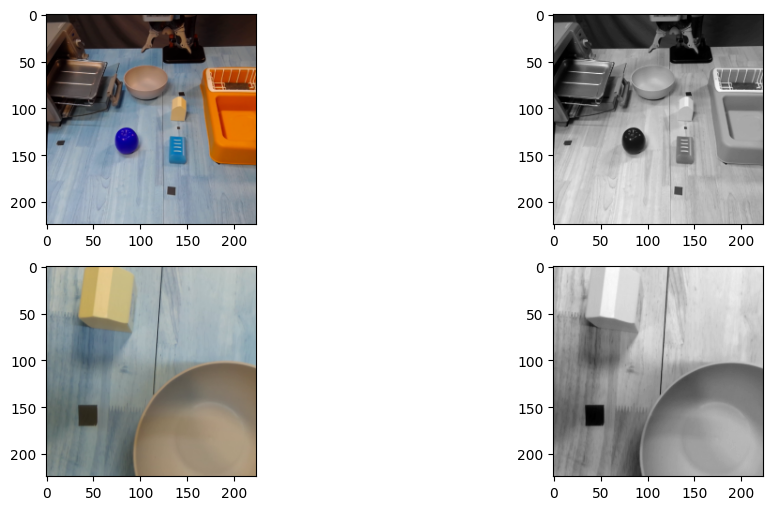

Gripper position: [-0.001232 -0.001232]


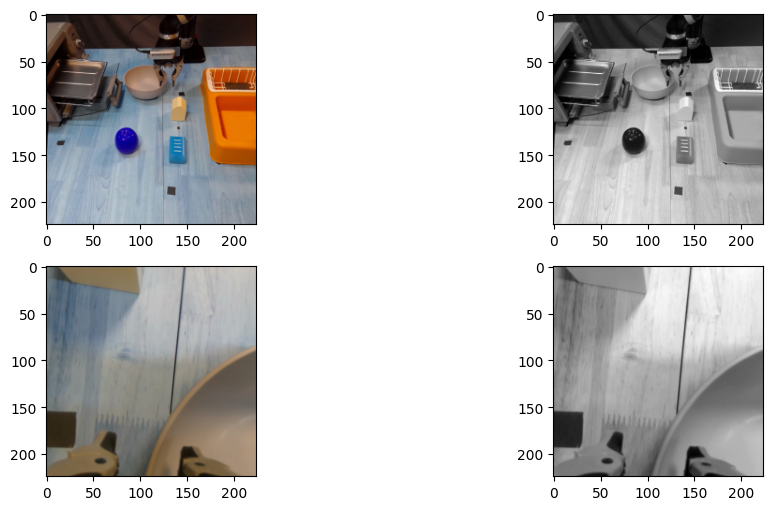

Gripper position: [0.95726176 0.95602976]


In [13]:
_idx = 0
with h5py.File(FILE_PATH, 'r') as h5_file:
    _img_front = h5_file["front_cam_ob"][_idx]
    _img_top = h5_file["mount_cam_ob"][_idx]
    _action = h5_file["actions"][_idx]
    _pos_ob = h5_file["ee_cartesian_pos_ob"][_idx]
    _vel_ob = h5_file["ee_cartesian_vel_ob"][_idx]
    _joint_ob = h5_file["joint_pos_ob"][_idx]

fig, axis = plt.subplots(2,2, figsize=(12,6))
axis[0,0].imshow(_img_front)
axis[0,1].imshow(
    to_greyscale(_img_front.astype(int)[None,:]).astype(np.float16).squeeze(), cmap=plt.get_cmap('gray')
)
axis[1,0].imshow(_img_top)
axis[1,1].imshow(
    to_greyscale(_img_top.astype(int)[None,:]).astype(np.float16).squeeze(), cmap=plt.get_cmap('gray')
)
plt.show()

print("Gripper position: {}".format(_joint_ob[-2:]))


_idx = 50
with h5py.File(FILE_PATH, 'r') as h5_file:
    _img_front = h5_file["front_cam_ob"][_idx]
    _img_top = h5_file["mount_cam_ob"][_idx]
    _action = h5_file["actions"][_idx]
    _pos_ob = h5_file["ee_cartesian_pos_ob"][_idx]
    _vel_ob = h5_file["ee_cartesian_vel_ob"][_idx]
    _joint_ob = h5_file["joint_pos_ob"][_idx]

fig, axis = plt.subplots(2,2, figsize=(12,6))
axis[0,0].imshow(_img_front)
axis[0,1].imshow(
    to_greyscale(_img_front.astype(int)[None,:]).astype(np.float16).squeeze(), cmap=plt.get_cmap('gray')
)
axis[1,0].imshow(_img_top)
axis[1,1].imshow(
    to_greyscale(_img_top.astype(int)[None,:]).astype(np.float16).squeeze(), cmap=plt.get_cmap('gray')
)
plt.show()

print("Gripper position: {}".format(_joint_ob[-2:]))

#EDA: Analyse Attributes "front_cam_ob", "mount_cam_ob"

I randomly sample 1000 each for images of "front_cam_ob" and "mount_cam_ob". Then I simple check the shape of them since checking all images takes 30 mins to run.

In [14]:
import numpy as np
from tqdm import tqdm  # For progress bar
# Number of random samples to analyze
NUM_SAMPLES = 1000  # Adjust this number based on your dataset size

# Analyze consistency of shapes using random sampling
with h5py.File(FILE_PATH, 'r') as h5_file:
    # Get total number of samples
    total_samples = len(h5_file["front_cam_ob"])
    print(f"Total samples in dataset: {total_samples}")

    # Randomly select indices
    random_indices = np.random.choice(total_samples, NUM_SAMPLES, replace=False)
    print(f"Randomly sampling {NUM_SAMPLES} indices for analysis...")

    # Front camera images
    front_cam_shapes = []
    print("Analyzing shapes for front_cam_ob...")
    for idx in tqdm(random_indices, desc="Processing front_cam_ob"):
        front_cam_shapes.append(h5_file["front_cam_ob"][idx].shape)
    unique_front_shapes = set(front_cam_shapes)
    print(f"Unique shapes in front_cam_ob (sampled): {unique_front_shapes}")

    # Mount camera images
    mount_cam_shapes = []
    print("Analyzing shapes for mount_cam_ob...")
    for idx in tqdm(random_indices, desc="Processing mount_cam_ob"):
        mount_cam_shapes.append(h5_file["mount_cam_ob"][idx].shape)
    unique_mount_shapes = set(mount_cam_shapes)
    print(f"Unique shapes in mount_cam_ob (sampled): {unique_mount_shapes}")

    # Quick check if all shapes are the same in the sampled data
    if len(unique_front_shapes) == 1:
        print("All sampled front_cam_ob images have the same shape.")
    else:
        print("Sampled front_cam_ob images have varying shapes.")

    if len(unique_mount_shapes) == 1:
        print("All sampled mount_cam_ob images have the same shape.")
    else:
        print("Sampled mount_cam_ob images have varying shapes.")

Total samples in dataset: 77965
Randomly sampling 1000 indices for analysis...
Analyzing shapes for front_cam_ob...


Processing front_cam_ob: 100%|██████████| 1000/1000 [01:22<00:00, 12.19it/s]


Unique shapes in front_cam_ob (sampled): {(224, 224, 3)}
Analyzing shapes for mount_cam_ob...


Processing mount_cam_ob: 100%|██████████| 1000/1000 [01:21<00:00, 12.20it/s]

Unique shapes in mount_cam_ob (sampled): {(224, 224, 3)}
All sampled front_cam_ob images have the same shape.
All sampled mount_cam_ob images have the same shape.


# FUN Mathematical Argument: High Likelihood of Consistent Shapes in All Samples(77965)

## Key Facts
- Total samples: **77,965**
- Randomly sampled: **1,000**
- Observation: **All 1,000 sampled shapes are the same** for both `front_cam_ob` and `mount_cam_ob`.

---

## 1. Probability of Shape Variance in Random Sampling

Let $p$ be the probability of a sample having a different shape. If $p > 0$, the probability of randomly selecting 1,000 samples and observing no variance is given by:

$$
P(\text{All 1000 same shape}) = (1 - p)^{1000}
$$

If shape variance exists ($p > 0$), this probability decreases exponentially with $p$. For example:
- If $p = 0.01$ (1% of samples have different shapes):

$$
P(\text{All 1000 same shape}) = (0.99)^{1000} \approx 0.000043
$$

- If $p = 0.001$ (0.1% of samples have different shapes):

$$
P(\text{All 1000 same shape}) = (0.999)^{1000} \approx 0.37
$$

Since we observed no variance in the 1,000 samples, the probability $p > 0$ is exceedingly small, suggesting $p$ is very close to 0.

---

## 2. Central Limit Theorem and Sampling Size

The **Central Limit Theorem (CLT)** states that a sufficiently large random sample approximates the population characteristics. With 1,000 samples ($\sim 1.28\%$ of the total dataset), the sample size is large enough to represent the population distribution.

Observing no variance in this large sample strongly implies that the variance in the entire population is negligible or zero.

---

## 3. Confidence Interval for Proportion of Variance

We can calculate a 95% confidence interval for the probability of shape variance ($p$) using the binomial distribution formula. For $n = 1000$ and $\hat{p} = 0$ (no observed variance):

$$
p_{\text{upper}} = \frac{1.96}{\sqrt{n}}
$$

Substituting $n = 1000$:

$$
p_{\text{upper}} = \frac{1.96}{\sqrt{1000}} \approx 0.0619 \quad (\text{6.19\%})
$$

This means that with 95% confidence, the true proportion of samples with a different shape is less than 6.19%. However, since we observed zero variance, the actual proportion is likely much smaller, possibly zero.

---

## Conclusion

Given:
1. **No variance** in the sampled 1,000 images.
2. The **low probability** of observing no variance in the sample if variance existed.
3. The **sample size** (1,000) being large enough to represent the population.
4. The **confidence interval** indicating negligible variance in the population.

It is **highly likely** that all 77,965 samples in the dataset share the same shape.(I actually tested them all)

As a result, no need to resize them.



===


#Check if we need normalize pixel values

Total samples in dataset: 77965
Randomly sampling 100 images for analysis...



Checking pixel ranges: 100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


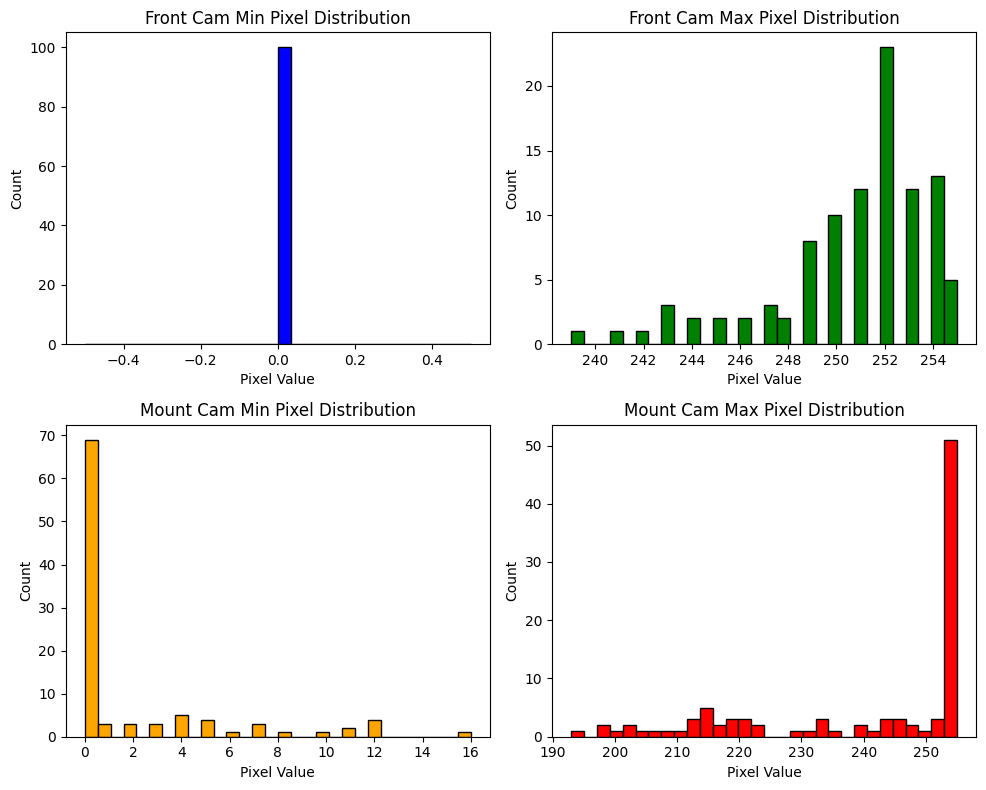

In [13]:
import matplotlib.pyplot as plt

NUM_SAMPLES = 100  # Number of samples to consider
np.random.seed(66)  # For reproducibility

with h5py.File(FILE_PATH, 'r') as h5_file:
    total_samples = len(h5_file["front_cam_ob"])
    print(f"Total samples in dataset: {total_samples}")

    # Randomly select indices
    random_indices = np.random.choice(total_samples, NUM_SAMPLES, replace=False)
    print(f"Randomly sampling {NUM_SAMPLES} images for analysis...\n")

    front_min_vals = []
    front_max_vals = []
    mount_min_vals = []
    mount_max_vals = []

    # Collect min and max values for the sampled images
    for idx in tqdm(random_indices, desc="Checking pixel ranges"):
        front_img = h5_file["front_cam_ob"][idx]
        mount_img = h5_file["mount_cam_ob"][idx]

        # Record min and max pixel values for front camera images
        front_min_vals.append(front_img.min())
        front_max_vals.append(front_img.max())

        # Record min and max pixel values for mount camera images
        mount_min_vals.append(mount_img.min())
        mount_max_vals.append(mount_img.max())

# Plot histograms of the min and max distributions
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Front cam distributions
axs[0, 0].hist(front_min_vals, bins=30, color='blue', edgecolor='black')
axs[0, 0].set_title('Front Cam Min Pixel Distribution')
axs[0, 0].set_xlabel('Pixel Value')
axs[0, 0].set_ylabel('Count')

axs[0, 1].hist(front_max_vals, bins=30, color='green', edgecolor='black')
axs[0, 1].set_title('Front Cam Max Pixel Distribution')
axs[0, 1].set_xlabel('Pixel Value')
axs[0, 1].set_ylabel('Count')

# Mount cam distributions
axs[1, 0].hist(mount_min_vals, bins=30, color='orange', edgecolor='black')
axs[1, 0].set_title('Mount Cam Min Pixel Distribution')
axs[1, 0].set_xlabel('Pixel Value')
axs[1, 0].set_ylabel('Count')

axs[1, 1].hist(mount_max_vals, bins=30, color='red', edgecolor='black')
axs[1, 1].set_title('Mount Cam Max Pixel Distribution')
axs[1, 1].set_xlabel('Pixel Value')
axs[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()



All pixel values remain within a standard 8-bit image range (0 to 255).

Minimum values are generally close to zero, indicating no images are missing darker tones.

Maximum values are generally high (often near 255), meaning no images are missing brighter tones.

There is some variation, but nothing suggests a drastically different pixel scale or a need for specialized normalization.

## Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions

In [6]:
_keys = [
    "actions","front_cam_ob",
    "mount_cam_ob","terminals",
    "ee_cartesian_pos_ob",
    "ee_cartesian_vel_ob",
    "joint_pos_ob"
    ]
train_nps = load_all_files(train_dh.loc,"train_[0-9]+.h5",keys=_keys)
val_nps = load_all_files(val_dh.loc,"val_[0-9]+.h5",keys=_keys)

100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


### Question 1.a Preprocessing
Most likely in machine learning pipelines, input data needs to be preprocessed before passing it to the model. This question requires you to specify the preprocessing that you will perform for the different types of data i.e., front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob. The dataset class provided in the associated "comp0188_cw2" package enables you to pass a dictionary of functions to preprocess each element of the observations and actions. The class expects a dictionary of transformations to apply to each input/output.

#### Question 1.a.i Preprocessing steps (5 marks)

##### Task
- Complete the dictionaries below, specifying the type of transformations you wish to perform. For each element (of the observations and actions), you should __at least__ convert the output to a tensor thus, these transformations have been implemented for you. You may alter __any__ part of the code between the "INSERT YOUR CODE HERE" comments

In [ ]:
# ******* INSERT YOUR CODE HERE *******

global_transforms = {
    "front_cam_ob":
        transforms.Compose([
            transforms.ToTensor()
            ]),
    "mount_cam_ob": transforms.Compose([
            transforms.ToTensor()
            ]),
    "actions": lambda x: torch.tensor(x),
    "ee_cartesian_pos_ob": lambda x: torch.tensor(x),
    "ee_cartesian_vel_ob": lambda x: torch.tensor(x),
    "joint_pos_ob": lambda x: torch.tensor(x)
}

# ******* INSERT YOUR CODE HERE - END *******

#### Question 1.a.ii Justification (5 marks)
##### Task
- In the markdown cell below, justify your decisions for preprocessing including where you have decided __not__ to apply preprocessing. You should include empirical evidence from your EDA analysis to support your decisions. Justfication __without__ evidence will be rewarded 0 marks.

_actions_


_front_cam_ob_


_mount_cam_ob_


_ee_cartesian_pos_ob_


_ee_cartesian_vel_ob_


_joint_pos_ob_

### Question 1.b End-to-end supervised model evaluation
The code below defines an end to end supervised model which:
- Jointly encodes the two images ("front_cam_ob", "mount_cam_ob") using a CNN architecture (image_encoder);
- Seperately encoding the positional and velocity observations using an MLP;
- Combines the two embeddings by adding them together and;
- Passes the combined embedding into a final MLP layer (dense)
  
This question requires you to define sutable loss functions for the model and then evaluate the performance.

In [ ]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]
    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

#### Question 1.b.i Loss definitions (3 marks)
For the model defined above, the proposed loss function is defined where the contribution of "pos_criterion" and "grp_criterion" are equally weighted and the mean of the two values loss are used to define the final loss. Furthermore, the loss for the positional actions is the MSE and the loss for grp_criterion is the CrossEntropyLoss.

##### Task:
- Justify why this composite loss function is reasonable. You should make reference to the range of values predicted by the deep learning model.

In [ ]:

pos_criterion = nn.MSELoss(reduction="mean")
grp_criterion = nn.CrossEntropyLoss(reduction="mean")

In [ ]:
torch.manual_seed(1)
model.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model.__repr__()


if exp_kwargs["half_precision"]:
    model = model.half()
optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            with torch.autocast(device_type="cuda"):
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            res = model(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))


In [ ]:
mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    preds_save_type=None
)

wandb_name = "End_to_end_1"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"


orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()

#### Question 1.b.ii Model evaluation (marks broken down in sub questions)
This question requires you to evaluate the perfomance of the model defined above by interpreting model training/validation metrics and investigating the specific failure modes of the model. Run the cells above which will train the model for 10 epochs.

**IMPORTANT, for questions (1.b.ii.i, 1.b.ii.ii, 1.b.ii.ii)**
- You are **not** expected to train a baseline model and you will be awarded **0 marks** for training such a model and evaluating performance against it.
- Furthermore, when interpretting the metric(s) and justifying your conclusions, you will loose marks for failing to comment on striking results that are obvious to the marker.
- **Incorrect interpretations of metrics** will be **negatively penalised**
- Finally, where you have been asked for empirical evidence, but provide none, you will be awarded __0 marks__.

#### Question 1.b.ii.i Epoch selection (3 marks)
##### Task
- Select an appropriate epoch using a suitable method, provide __empirical evidence__ for your choice.

#### Question 1.b.ii.ii Performance evaluation (8 marks)
##### Task
- Draw conclusions regarding how well the model performs. To do this you may want to use additional metrics to the one(s) already reported. Critically, you should __contextualise__ the performance of the model. We are expecting discussion points a long the lines: _The model achieved a score of X according to metric Y. This suggests that the model is/is not performing well, because..._

#### Question 1.b.ii.iii Model failure modes (9 marks)
##### Task
- Investigate the failure modes of the model. You should:
  - Demonstrate the failure mode using **empirical evidence** e.g., _the model fails on X observations as demonstrated by..._
  - Assess the impact of these failure modes using **empirical evidence** i.e., how significant is this problem. You should consider both metrics and dataset coverage
  - Conclude __why__ the model might be failing on these observations **empirical evidence** e.g., _X part of the model performs poorly, as demonstrated by..._

__IMPORTANT__:
- Marks will be penalised if the failure modes you identify are not systematic i.e., you select a single observation that the model fails on. If you cannot identify any general failure modes of the model, you will be awarded full marks if you provide empirical evidence justifying why there are no systematic failure modes which sufficienty accounts for the diversity of observations in the dataset.


### Question 1.c Model tuning
Now you have evaluated the proposed model, you are required to iterate and train a higher performing one. You are expected to run experiments that help you understand where the model is underperforming, guiding your development.

#### Question 1.c.i Model tuning (5 marks)
##### Task
- Using the code blocks below, implement a model which improves over the previous. Improve the performance as best you can and report the results using the metric/metrics you used in question 1.b.ii Model evaluation. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [ ]:
# ******* INSERT YOUR CODE HERE *******

# ******* INSERT YOUR CODE HERE - END *******

#### Question 1.c.ii Discussion (marks broken down in subsections below)

##### Task
In the markdown blocks below, discuss **three** experiments that you ran during the development of your model, defined in 1.c.i Model tuning which were the **most insightful** with respect to the design of your final model. Importantly, **most insightful** needn't necessarily be the final decisions that appear in the model defined in question 1.c.i Model tuning, rather they should be experiments that most shaped your model development process. For example:
- You might decide to use a learning rate scheduler and decrease the learning rate at epoch 10 (call this experiment "EXP_LR");
- This experiment produces a jump in performance and unlocks a series of further fruitful experiments into learning rate scheduling;
- However, in the model reported in question 1.c.i Model tuning, you use a learning rate schedule with descreases at epochs 6 and 15 (since these produced a marginal performance over "EXP_LR")
- For this question __you should discuss EXP_LR__.
  
For each experiment, complete the "Description", "Result" and "Conclusion" sections where the following information should be provided:
* __Description__: What delta were you measuring i.e., change of architecture, change of learning rate etc?
* __Justification__: **Why** are you conducting the experiment?
  * What was the context of the model development process up to this point? What did you already know about how well the model performed/why it was performing/what were the challenging data points?
* __Conclusion__: What did you __learn__ from the experiment and provide __empirical evidence__ to support this claim. In drawing your conclusions, consider where there are multiple possible causes for the model failing, ensure you provide evidence for each of these and conclude whether or not they might be root cause (you may conclude that there are multiple causes).

**IMPORTANT** If your reported experiments are **not** well motivated and do not demonstrate that you have integrogated the model performance, you will be deducted marks. An example of poor motovation might be: *I chose to decrease the learning rate from X to Y as I did not know what impact this might have*. This justification could be improved by explaining what you __already know__ about how the learning rate might be affecting the model. What hypotheses might you draw about what the experiment will show?



#### Question 1.c.ii.i Experiment 1 discussion (10 marks)

##### Description


##### Justification


##### Conclusion

#### Question 1.c.ii.ii Experiment 2 discussion (10 marks)

##### Description


##### Justification


##### Conclusion

#### Question 1.c.ii.iii Experiment 3 discussion (10 marks)

##### Description


##### Justification


##### Conclusion

### Question 2 Self-supervised pretraining with VAEs

This question requires you to implement a self-supervised approach using a VAE architecture. The focus of question 2 is in developing a VAE model without using __any__ supervised information i.e., without using any action information. You will assess the convergence of the model and the suitability of the learnt latent space. You are required to select and appropriate architecture/loss function/target set of observations to perform self-supervised learning over.

__IMPORTANT__: Do not use any of the __action__ information. You will be awarded 0 marks if you do.

### Question 2.a Self-supervised VAE model (5 marks)

##### Task
- Implement the full model training process and model definiton in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [ ]:
# ******* INSERT YOUR CODE HERE *******


# ******* INSERT YOUR CODE HERE - END *******

### Question 2.b Model convergence (12 marks)

##### Task
- Provide empirical evidence (in the form of appropriate training/validation metrics) supporting **why** the model is appropriately trained;
- Interpret why the metrics demonstrate that the model has converged. If your model has **not** converged, interpret why the metrics suggest so.

### Question 2.c Latent space analysis (6 marks)

##### Task
- Using reasonable analysis, conclude whether the representation learnt by the self-supervised method will be beneficial for the downstream supervised task. **Empirical evidence** should be provided **however**, references to the performance of the self-superised method with a supervised head on the downstream task will be awarded __0 marks__.

### Question 3 Full model training
This question requires you to first develop a supervised head which utilises the latent space from your self-supervised method. You are then required to assess the models performance as well as the model you developed in question 1.c.i on the test set, report the performance and conclude whether self-supervised learning is appropriate for this task.

### Question 3.a Combining self-supervised model with the downstream task (5 marks)

##### Task
- Develop a model which combines the self-supervised pretraining with a model for performing the downstream task by freezing the self-supervised model and fine-tuning a head for prediction and implement it in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions). The supervised head should at least include any inputs that you did not feed into the self-supervised model. For example, assume you decide to perform self-supervised learning only using front_cam_ob images. You must also include mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob observations in your model.

In [ ]:
# ******* INSERT YOUR CODE HERE *******


# ******* INSERT YOUR CODE HERE - END *******

### Question 3.b Assessing the suitability of self-supervised learning
For the final two questions, you are required to assess the performance of the self-supervised + supervised head model and the end-to-end model that you have trained. Additionally, you are required to holistically evaluate whether self-supervised learning has been beneficial for this task.

#### Question 3.b.i Assessing the suitability of self-supervised learning (4 marks)

##### Task
- In the code block below, evaluate the performance of the model you trained in question 3.a and the model you trained in question 1.c.i, using the test set. Additionally use the same metrics to train and evaluate the model that you used for question 1.c.i. Markers should be able to run the cell such that both models are run on the appropriate dataset. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [ ]:
# ******* INSERT YOUR CODE HERE *******


# ******* INSERT YOUR CODE HERE - END *******

#### Question 3.b.ii Justification (5 marks)

##### Task
- Conclude whether the self-supervised pre-training was beneficial for the task of predicting actions. Your answer should not solely focus on final performance but rather be nuianced and balance other model development considerations for example parameter count and speed of convergence. Also, if you believe the comparison between the model trained in question 3.a.i aganst the model trained in question 2.c.i is not _fair_, discuss further experiments which you would perform to reduce the bias in your conclusions. Provide __empirical evidence__ to support your conclusions. __0 marks__ will be awarded if empirical evidence is __not__ provided.